# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [372]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [373]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [374]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head().style.hide_index()

offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,January,Malbec,72,56,France,False
2,January,Pinot Noir,72,17,France,False
3,February,Espumante,144,32,Oregon,True
4,February,Champagne,72,48,France,True
5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [375]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head().style.hide_index()

customer_name,offer_id,n
Smith,2,1
Smith,24,1
Johnson,17,1
Johnson,24,1
Johnson,26,1


In [376]:
df_transactions.shape

(324, 3)

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [377]:
#your turn
transact_pivot = df_transactions.pivot_table(index='customer_name', columns='offer_id')
transact_pivot.columns = [col[1] for col in transact_pivot.columns]
transact_pivot.fillna(0, inplace=True)
random_state = None
transact_pivot.head(6)

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Barnes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Now to generate the table of transactions that merges in all of the data from the offers table.

In [378]:
transact_merged = pd.merge(df_transactions, df_offers, on='offer_id')
transact_merged.head().style.hide_index()

customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
Smith,2,1,January,Pinot Noir,72,17,France,False
Rodriguez,2,1,January,Pinot Noir,72,17,France,False
Martin,2,1,January,Pinot Noir,72,17,France,False
Jackson,2,1,January,Pinot Noir,72,17,France,False
Campbell,2,1,January,Pinot Noir,72,17,France,False


In [379]:
transact_merged.shape, df_transactions.shape

((324, 9), (324, 3))

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Lower values of SS represent better clusterings.  SS means 'sum of squres' which is an error differential that should be minimized.

In [380]:
x_cols = np.array(transact_pivot)
x_cols[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [381]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

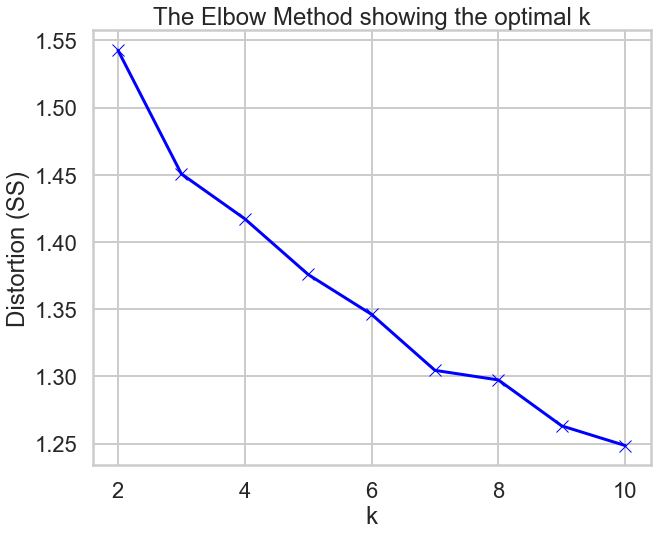

In [382]:
distortions = []
label_sets = {}
K = range(2,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x_cols)
    distortions.append(sum(np.min(cdist(x_cols, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x_cols.shape[0])
    label_sets[k] = kmeanModel.labels_
    
plt.figure(figsize=[10,8])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion (SS)')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Use 7 as the value of k based on there being an elbow there.  Due to randomization, this plot is subject to change each time it is run.  Values between 5 and 7 are all reasonable.

In [383]:
label_sets[7]

array([0, 2, 1, 6, 4, 4, 1, 6, 2, 6, 3, 1, 6, 4, 2, 1, 2, 1, 6, 2, 6, 2,
       2, 3, 1, 3, 2, 2, 4, 2, 2, 0, 2, 5, 2, 0, 2, 6, 3, 0, 1, 1, 2, 4,
       0, 5, 6, 2, 2, 3, 2, 4, 3, 1, 4, 6, 1, 2, 0, 4, 4, 2, 4, 0, 6, 3,
       1, 2, 3, 2, 2, 2, 5, 0, 4, 6, 1, 2, 0, 2, 2, 3, 2, 1, 6, 0, 6, 3,
       2, 2, 5, 0, 2, 6, 2, 4, 6, 3, 5, 4])

In [384]:
cluster_populations = pd.DataFrame(pd.DataFrame(label_sets[7]).value_counts())

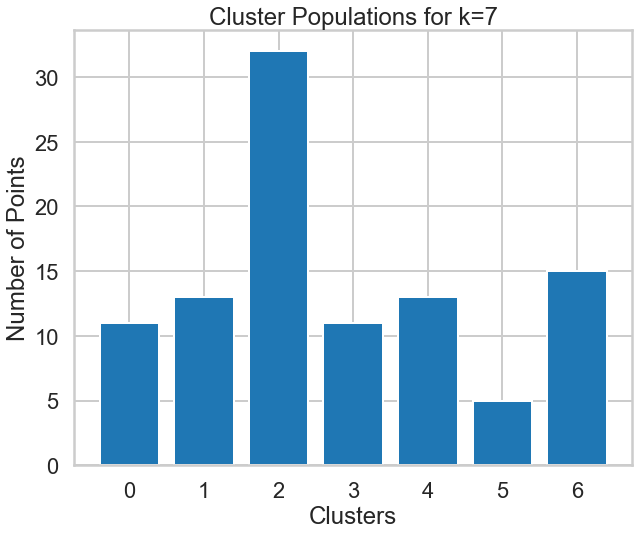

In [385]:
plt.figure(figsize=[10,8])
plt.bar([i[0] for i in cluster_populations.index.values], cluster_populations[0])
plt.xlabel('Clusters')
plt.ylabel('Number of Points')
plt.title('Cluster Populations for k=7')
plt.show()

The challenge to picking the elbow is the complexity of the curve which is supbject to change with each randomization.

In [386]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

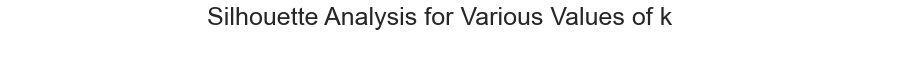

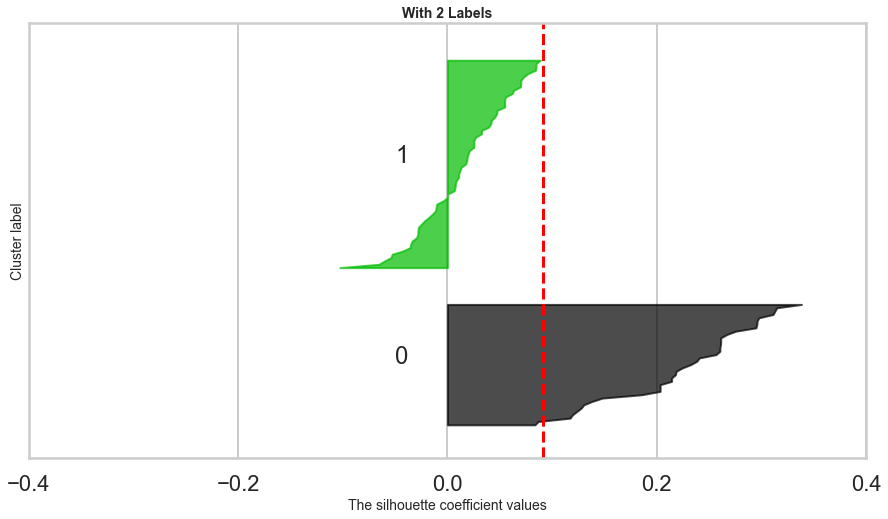

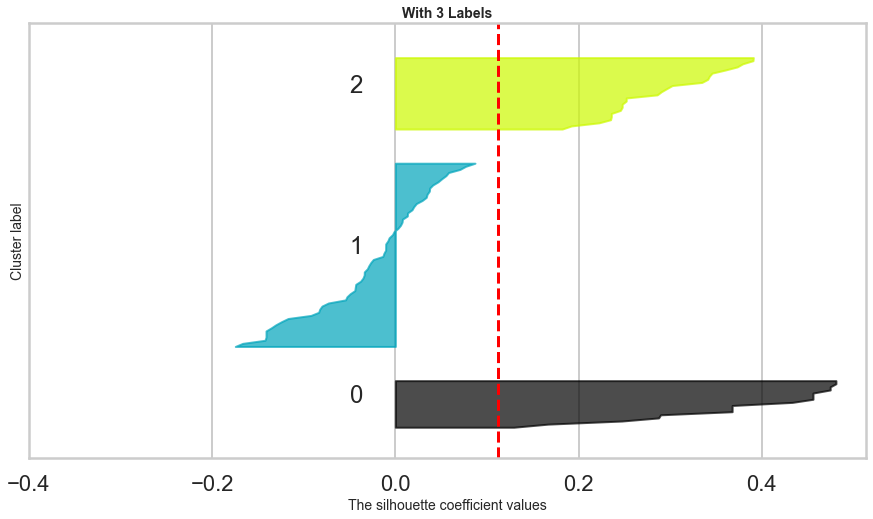

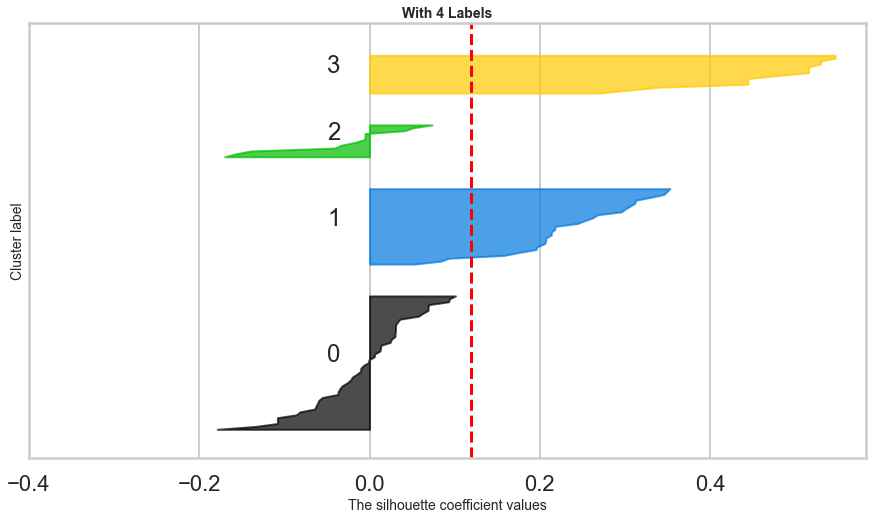

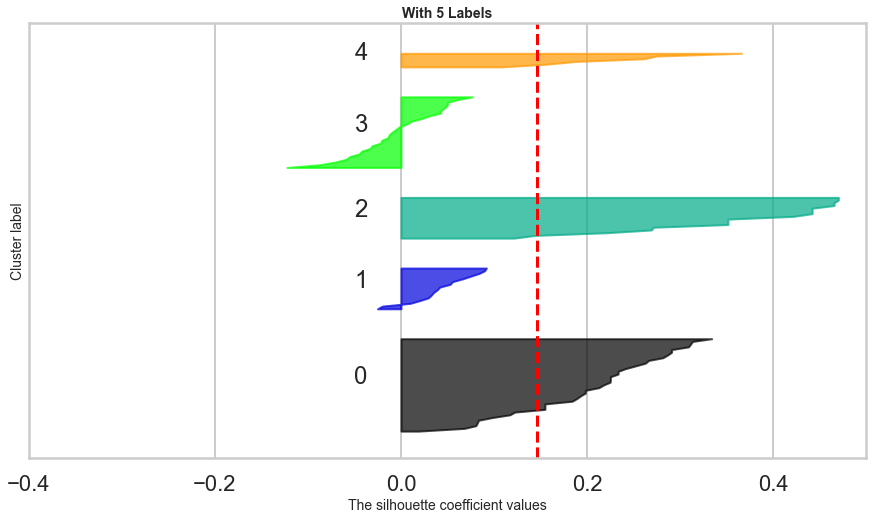

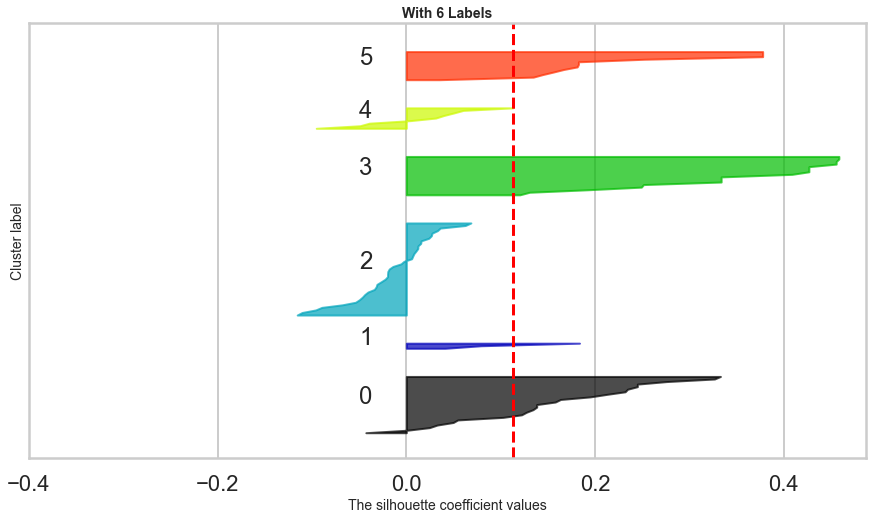

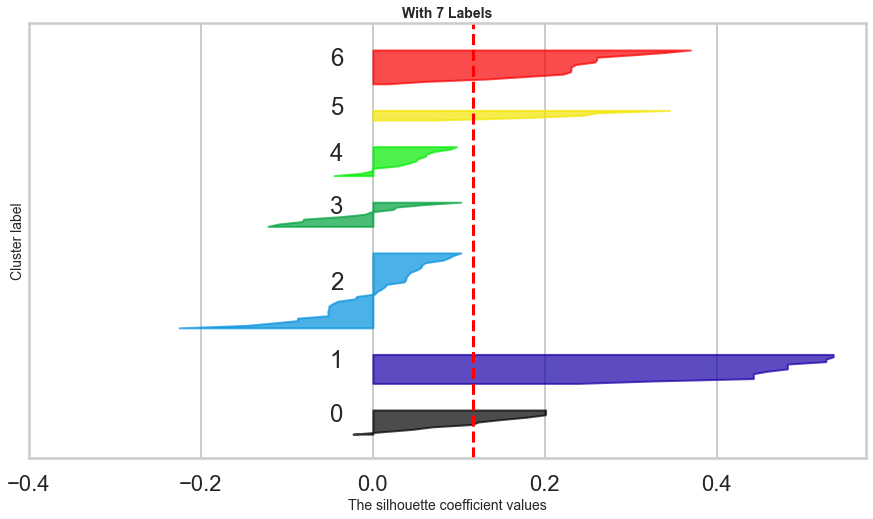

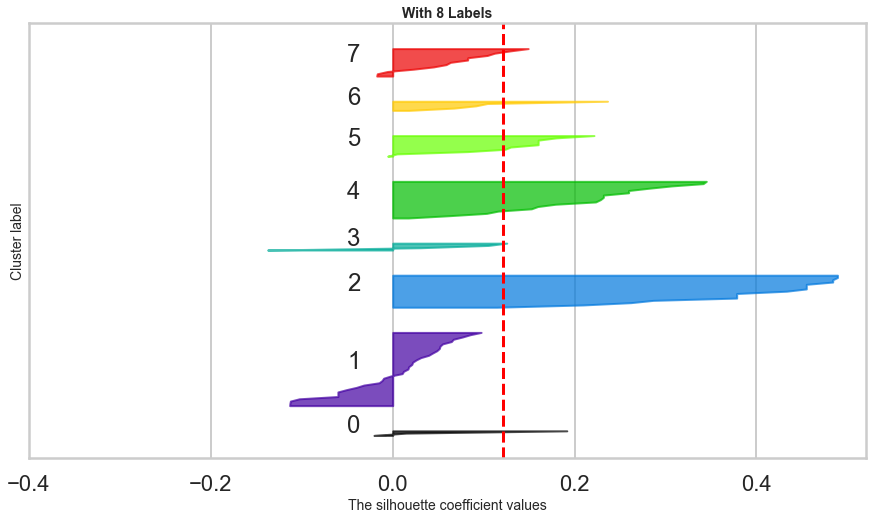

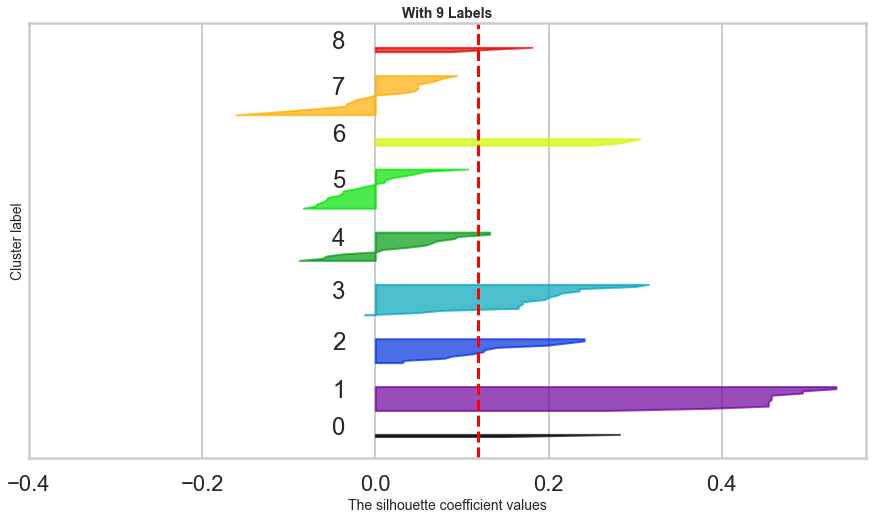

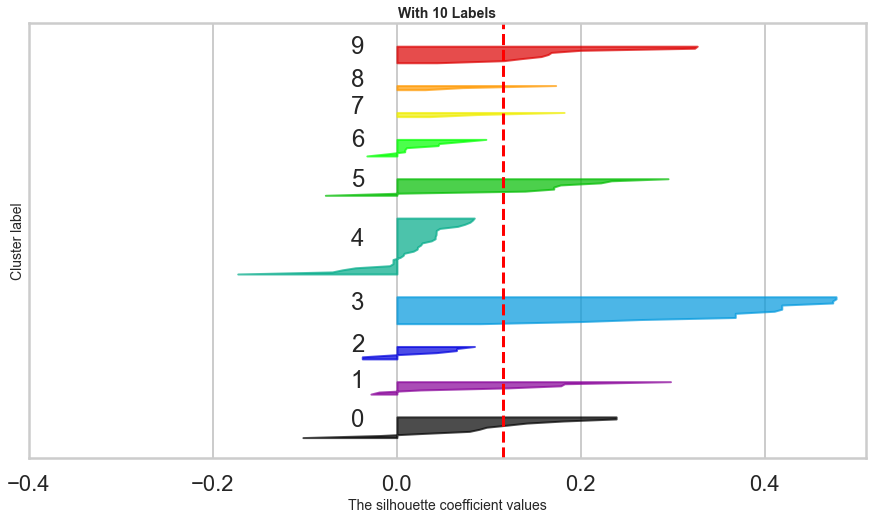

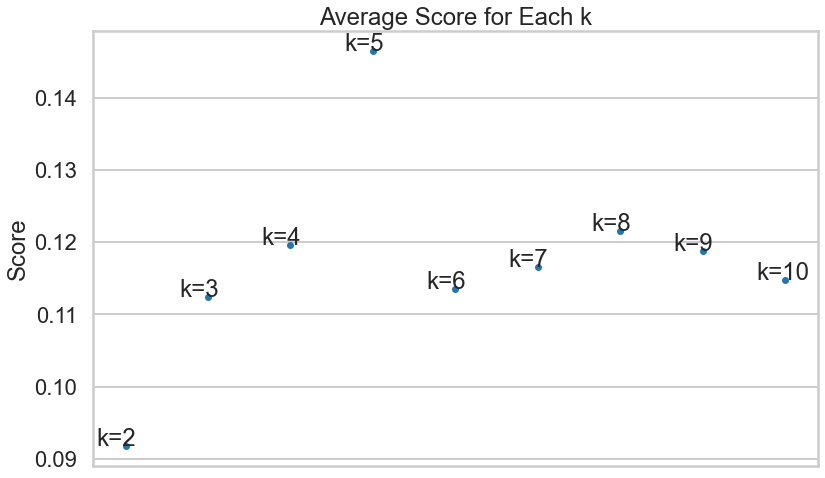

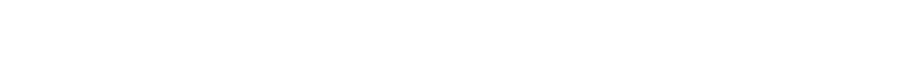

In [387]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
title_fig, blank_axis = plt.subplots(nrows=1, ncols=2)
title_fig.suptitle('Silhouette Analysis for Various Values of k', fontsize=25)
title_fig.set_size_inches(16, 1)
blank_axis[1].axis('off')
blank_axis[0].axis('off')
average_scores = np.array([])
for n_clusters in range(2,11):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(15, 8)
    ax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, label_sets[n_clusters])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, label_sets[n_clusters])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[label_sets[n_clusters] == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(("With %d Labels" % n_clusters),
                 fontsize=14, fontweight='bold')
    ax.set_xlabel(("The silhouette coefficient values"), fontsize=14)
    ax.set_ylabel(("Cluster label"), fontsize=14)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    average_scores = np.append(average_scores, silhouette_avg)

    ax.set_yticks([])  # Clear the yaxis labels / ticks    
    ax.set_xticks(list(np.round(np.arange(-0.4, 0.6, 0.2), 2)))

plt.figure(figsize=[13,8])
plt.title("Average Score for Each k")
plt.scatter(np.arange(2,11), average_scores, s=25)
for i in range(2,11):
    plt.text(i-0.35, average_scores[i-2], 'k=' + str(i))
plt.xticks([])
plt.ylabel('Score')

bottom_fig, blank_axis = plt.subplots(nrows=1, ncols=2)
bottom_fig.set_size_inches(16, 1)
blank_axis[1].axis('off')
blank_axis[0].axis('off')

for i in range(3):
    print()

Make k 7.    Any higher would risk overfitting.  This is close to the value obtained above.

&nbsp;

&nbsp;

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [388]:
#your turn
from sklearn.decomposition import PCA

'transact_merged', is a wider version of 'df_transactions' which should be redefined in order to more fully take advantage of PCA:

In [389]:
df_transactions = transact_merged.copy()

In [390]:
len(df_transactions['campaign'].unique()), len(df_transactions['varietal'].unique()), \
len(df_transactions['min_qty'].unique()), len(df_transactions['discount'].unique()), \
len(df_transactions['origin'].unique()), len(df_transactions['past_peak'].unique())

(12, 9, 4, 27, 9, 2)

As shown above, the other fields have a limited set of possible values occuring within the available data.  Each of these fields can be used to form pivot tables leading to an expanded version of x_cols.

In [391]:
campaign_pivot = df_transactions[['customer_name', 'campaign', 'n']].pivot_table(index='customer_name', columns='campaign')
campaign_pivot.columns = [col[1] for col in campaign_pivot.columns]
campaign_pivot.fillna(0, inplace=True)
campaign_pivot.head()

,April,August,December,February,January,July,June,March,May,November,October,September
customer_name,,,,,,,,,,,,
Adams,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Allen,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Bailey,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Baker,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [392]:
varietal_pivot = df_transactions[['customer_name', 'varietal', 'n']].pivot_table(index='customer_name', columns='varietal')
varietal_pivot.columns = [col[1] for col in varietal_pivot.columns]
varietal_pivot.fillna(0, inplace=True)
varietal_pivot.head()

,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
customer_name,,,,,,,,,
Adams,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
Allen,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Bailey,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
Baker,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [393]:
min_qty_pivot = df_transactions[['customer_name', 'min_qty', 'n']].pivot_table(index='customer_name', columns='min_qty')
min_qty_pivot.columns = [col[1] for col in min_qty_pivot.columns]
min_qty_pivot.fillna(0, inplace=True)
min_qty_pivot.head()

,6,12,72,144
customer_name,,,,
Adams,1.0,0.0,0.0,0.0
Allen,0.0,0.0,1.0,1.0
Anderson,1.0,0.0,0.0,1.0
Bailey,1.0,0.0,0.0,0.0
Baker,1.0,1.0,1.0,0.0


In [394]:
discount_pivot = df_transactions[['customer_name', 'discount', 'n']].pivot_table(index='customer_name', columns='discount')
discount_pivot.columns = [col[1] for col in discount_pivot.columns]
discount_pivot.fillna(0, inplace=True)
discount_pivot.head().T.shape

(27, 5)

In [395]:
origin_pivot = df_transactions[['customer_name', 'origin', 'n']].pivot_table(index='customer_name', columns='origin')
origin_pivot.columns = [col[1] for col in origin_pivot.columns]
origin_pivot.fillna(0, inplace=True)

In [396]:
df_transactions['past_peak'].head()

0    False
1    False
2    False
3    False
4    False
Name: past_peak, dtype: bool

The 'past_peak' column has boolean values which becomes a problem for Pandas manipulations when these values become column headers via a pivot table.  Let's make these entries strings with values of 'true' and 'false', all lower case to keep Pandas from getting confused.

In [397]:
df_transactions['past_peak'] = df_transactions['past_peak'].astype(str)
df_transactions['past_peak'].head()

0    False
1    False
2    False
3    False
4    False
Name: past_peak, dtype: object

In [398]:
df_transactions.loc[df_transactions['past_peak'] == 'True', 'past_peak'] = 'true'

In [399]:
df_transactions.loc[df_transactions['past_peak'] == 'False', 'past_peak'] = 'false'

In [400]:
past_peak_pivot = df_transactions[['customer_name', 'past_peak', 'n']].pivot_table(index='customer_name', \
                                                                                   columns='past_peak')
past_peak_pivot.columns = [col[1] for col in past_peak_pivot.columns]
past_peak_pivot.fillna(0, inplace=True)

In [401]:
past_peak_pivot.head()

,false,true
customer_name,,
Adams,1.0,0.0
Allen,1.0,0.0
Anderson,1.0,0.0
Bailey,1.0,1.0
Baker,1.0,1.0


'Bailey' and 'Baker' have a value of 1.0 for both the 'false' and 'true' columns.  This might look wrong but it's actually O.K. because customers can place multiple orders with different values for each of the data fields including this one.

In [402]:
x_cols = np.array(pd.concat([transact_pivot, campaign_pivot, varietal_pivot, min_qty_pivot, \
           discount_pivot, origin_pivot, past_peak_pivot], axis=1))
X = x_cols

Sanity checks for x_cols:

In [403]:
print(x_cols.shape[1])
len(df_transactions['campaign'].unique()) + len(df_transactions['varietal'].unique()) + \
len(df_transactions['min_qty'].unique()) + len(df_transactions['discount'].unique()) + \
len(df_transactions['origin'].unique()) + len(df_transactions['past_peak'].unique()) + \
len(df_transactions['offer_id'].unique())

95


95

In [404]:
np.array(np.sum(pd.DataFrame(x_cols)==1))

array([10, 10,  6, 12,  4, 12, 19, 20, 10,  7, 13,  5,  6,  9,  6,  5,  7,
       14,  5,  6,  4, 21,  5, 12,  6, 15,  9,  6, 17, 22, 17,  4, 17, 28,
       39, 18, 16, 26, 16, 42, 23, 22, 28, 17, 22, 44, 13, 32, 29, 20, 17,
       23, 36, 60, 21, 58, 41, 10,  6,  6, 12,  5, 19,  6,  4, 24,  7, 12,
       17,  7, 22, 14, 10,  6, 21,  9,  5,  6, 19, 13, 12, 17, 13, 17, 37,
       15, 31, 72, 16, 23, 13, 26, 25, 97, 44], dtype=int64)

In [405]:
np.array(np.sum(pd.DataFrame(x_cols)==1) + np.sum(pd.DataFrame(x_cols)==0))

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100], dtype=int64)

Applying PCA to xcols:

In [406]:
pca = PCA(n_components=2)
pca.fit(x_cols)
x_cols = pca.transform(x_cols)

Calculating the labels:

In [407]:
kmeanModel = KMeans(n_clusters=7).fit(x_cols)

In [408]:
df_summary = pd.concat([pd.DataFrame(transact_pivot.index),  pd.DataFrame(kmeanModel.labels_),\
                        pd.DataFrame(x_cols)], axis=1)
df_summary.columns = [transact_pivot.index.name, 'cluster ID', 'pca_x', 'pca_y']

In [409]:
df_summary.head().style.hide_index()

customer_name,cluster ID,pca_x,pca_y
Adams,4,2.231437,0.169044
Allen,2,-1.446018,0.027672
Anderson,3,-0.691540,2.565095
Bailey,0,1.468335,-0.174562
Baker,6,0.271260,-0.683305


Generating a distortion plot and a set of labels for each value of k from 2 to 10 inclusive:

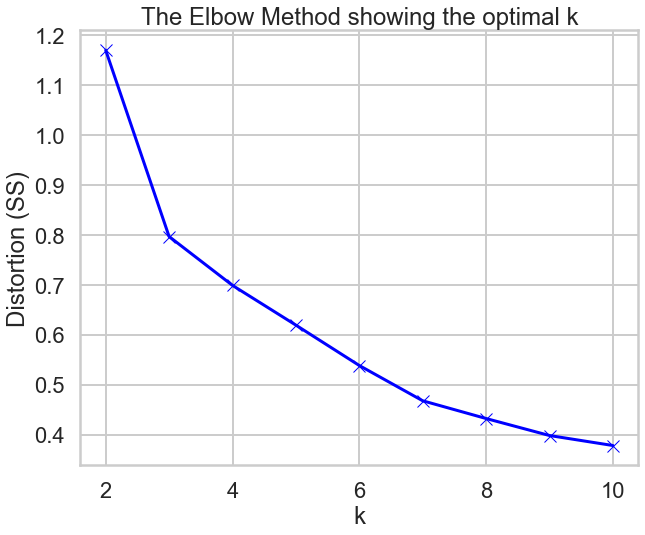

In [410]:
distortions = []
label_sets = {}
K = range(2,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x_cols)
    distortions.append(sum(np.min(cdist(x_cols, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x_cols.shape[0])
    label_sets[k] = kmeanModel.labels_
    
plt.figure(figsize=[10,8])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion (SS)')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Getting the silhouette scores:

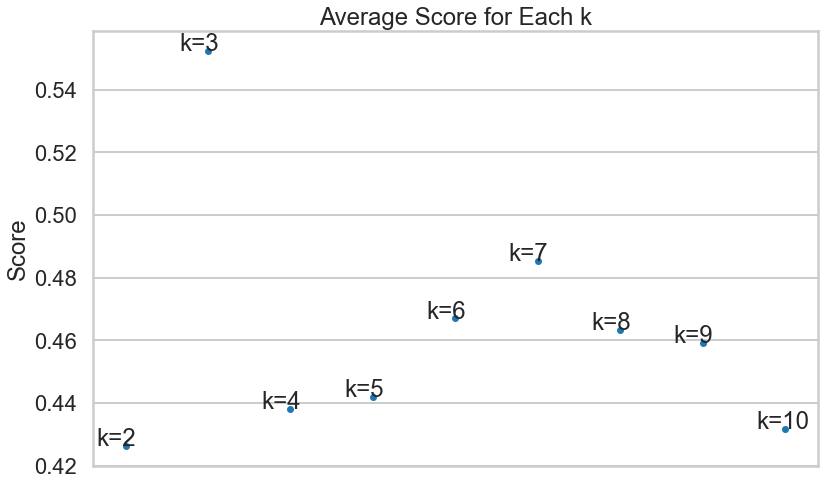

In [411]:
average_scores = np.array([])
for n_clusters in range(2,11):
    silhouette_avg = silhouette_score(x_cols, label_sets[n_clusters])
    average_scores = np.append(average_scores, silhouette_avg)

plt.figure(figsize=[13,8])
plt.title("Average Score for Each k")
plt.scatter(np.arange(2,11), average_scores, s=25)
for i in range(2,11):
    plt.text(i-0.35, average_scores[i-2], 'k=' + str(i))
plt.xticks([])
plt.ylabel('Score')
plt.show()

&nbsp;

Picking k=7 based on these two graphs:

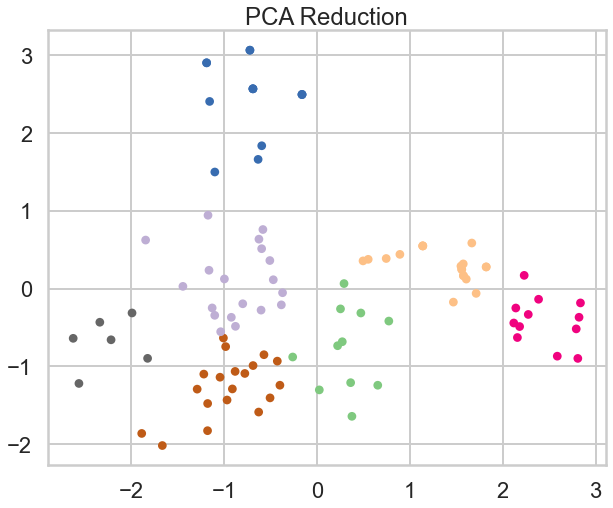

In [412]:
plt.figure(figsize=[10,8])
plt.scatter(df_summary['pca_x'], df_summary['pca_y'], c= label_sets[7], cmap = 'Accent', s=45)
plt.title('PCA Reduction')
plt.show()

The plot above shows viable clustering at k=7.  Every value from 2 to 10 shows real clustering.  Therefor, none of the methods discussed provide an optimal result visually.  The way to optimize is to use different clusterings in the wild and assess results thereof.

<b>Telling a story:<b>

Only 100 data points are provided for that exact same number of end users which is really too small for any segmentation into groups.  Given these limitations on data availability, let k=2 which is the lowest possible label count that can be regarded as meaningful.  This will allow us to decide if there are any behavioral differences between one cluster and the other.

&nbsp;

In [441]:
label_ID = KMeans(n_clusters=2).fit(x_cols).labels_

In [442]:
pd.DataFrame(label_ID).value_counts()

1    64
0    36
dtype: int64

An adjustment has to be made for the difference in size between the two clusters.

In [443]:
total_0s = pd.DataFrame(label_ID)[pd.DataFrame(label_ID)[0]==0].shape[0]
adjustment_km = (100 - total_0s)/total_0s
adjustment_km

1.7777777777777777

In [444]:
def display_comparison (options_dict, customer_preference, pane_title, label_set, adjustment):
    customer_preference['label_ID'] = label_set
    sales_outcomes = [[], []]
    for key in options_dict:
        sales_outcomes[0].append(adjustment*(customer_preference[(customer_preference['label_ID']==0) & \
                                                     (customer_preference[options_dict[key]])].shape[0]))
        sales_outcomes[1].append(customer_preference[(customer_preference['label_ID']==1) & \
                                                     (customer_preference[options_dict[key]])].shape[0])
        
    if pane_title in ['Monthly Order Flow', 'Sales by Wine Selection', 'Sales by Product Origin', 'Discounted Sales']:
        ax = plt.gca()
        ax.tick_params(axis = 'x', which = 'major', labelsize = 15)
    if pane_title == 'Discounted Sales':
        plt.xticks(list(np.arange(0, 110, 5)))
    plt.plot(options_dict.keys(), sales_outcomes[0], 'bx-', label='cluster ID 0', c='red')
    plt.plot(options_dict.keys(), sales_outcomes[1], 'bx-', label='cluster ID 1', c='black')
    plt.ylabel('number of sales (scaled)')
    plt.title(pane_title)
    plt.legend(loc="upper right")

In [445]:
def sales_plotter (labels, adjustmentFactor):
    fig = plt.figure(figsize=(20,25))
    fig.set_figwidth(15)
    fig.suptitle("Sales Outcome of Two-way Segmetation", fontsize=25)

    function_args = [(\
                    {'Jan':'January', 'Feb':'February', 'Mar':'March', 'Apr':'April', 'May':'May', 'Jun':'June', \
                    'Jul':'July','Aug':'August', 'Sep':'September', 'Oct':'October', 'Nov':'November', 'Dec':'December'},\
                    \
                    campaign_pivot, 'Monthly Order Flow'),\
                 
                   ({'Cab':'Cabernet Sauvignon', 'Cham':'Champagne', 'Char':'Chardonnay', 'Esp':'Espumante', \
                     'Mal':'Malbec', 'Mer':'Merlot', 'PG':'Pinot Grigio', 'PN': 'Pinot Noir', 'Pro': 'Prosecco'}, \
                      varietal_pivot, 'Sales by Wine Selection'),
                 
                     ({6:6, 12:12, 72:72, 144:144}, min_qty_pivot, 'Orders by Minimum Quantity'),

                   ({'true': 'true', 'false': 'false'}, past_peak_pivot, 'Impact of Past Peak Parameter'),\
                 
                   ({i:i for i in discount_pivot.columns}, discount_pivot, 'Discounted Sales'),\
                
                  ({'Aus':'Australia', 'Cal':'California', 'Chi':'Chile', 'Fra':'France', 'Ger':'Germany', 'Ita':'Italy',\
                   'NZ':'New Zealand', 'Ore':'Oregon', 'S Af':'South Africa'}, origin_pivot, 'Sales by Product Origin')]
                
                  

    for i in list(enumerate(function_args)):
        plt.subplot(3,2,i[0]+1)         
        display_comparison (i[1][0], i[1][1], i[1][2], labels, adjustmentFactor)

    for i in range(5):
        print()

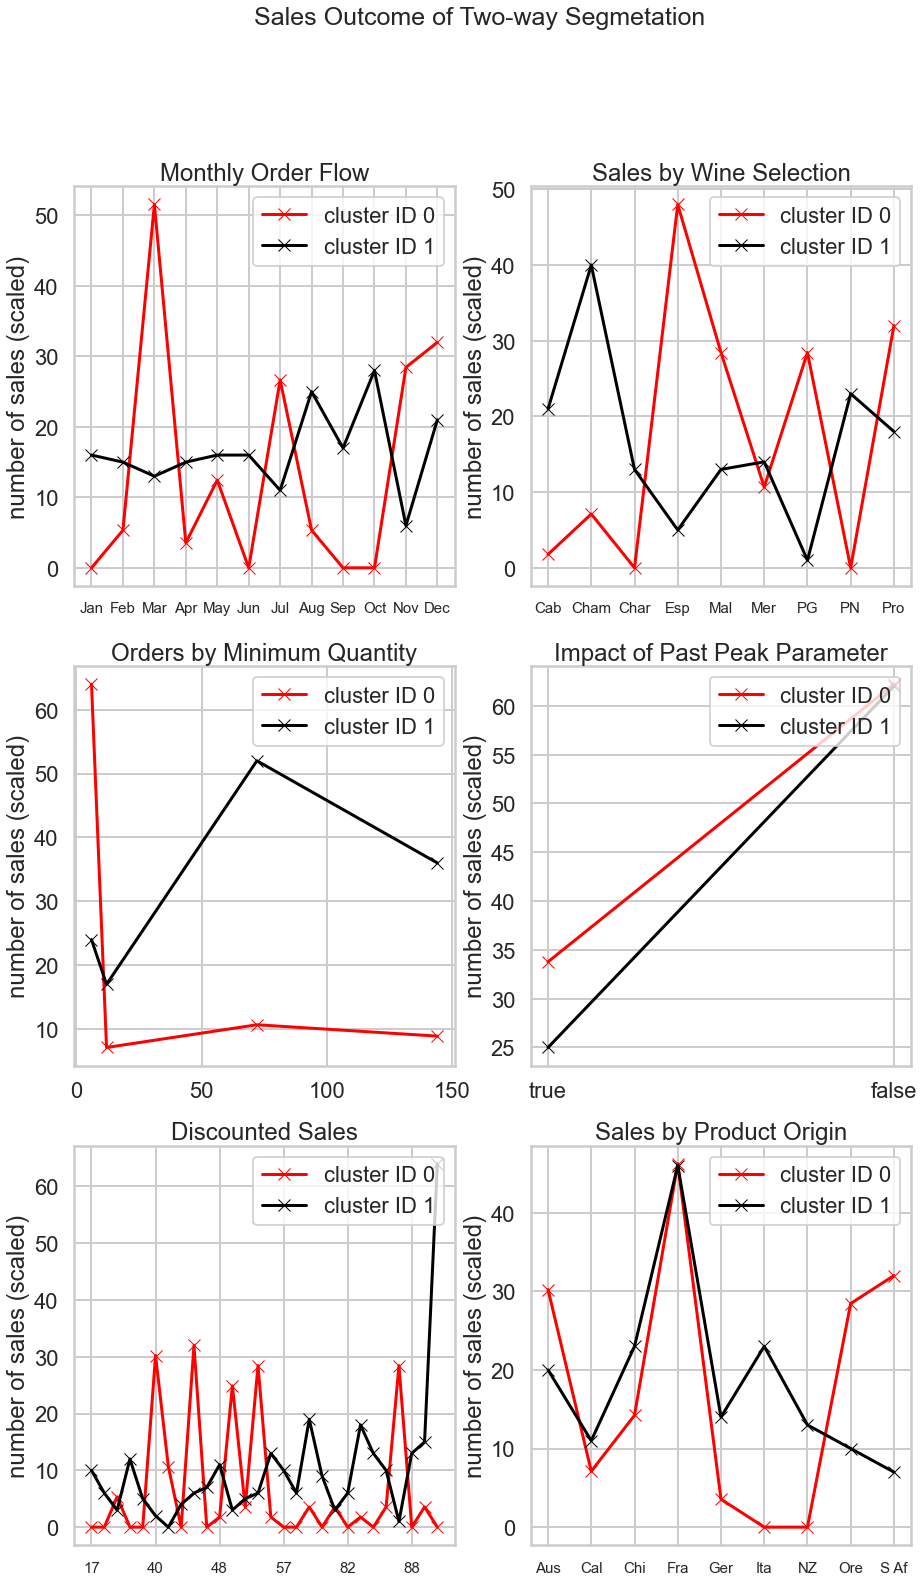

In [446]:
sales_plotter (label_ID, adjustment_km)

&nbsp;

Group 0 is more attracted to large minimum orders and group 1 is attracted to discounts and products that are past peak.

&nbsp;

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [419]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
pca.transform(X)[:4, :10]

array([[ 2.23143729,  0.16904446,  1.26969495,  0.38441666, -0.12963716,
         0.13519775,  0.43160927, -0.767002  ,  0.90121107,  0.76935135],
       [-1.44601793,  0.0276718 , -0.48136958,  1.33439899,  0.70828508,
        -0.59525315, -0.5701107 ,  0.26012099,  0.9158779 ,  0.9184303 ],
       [-0.6915404 ,  2.5650952 , -0.43413132, -0.16184731,  0.37599985,
        -0.01869956,  0.15784991, -0.11159555, -0.28471836,  0.11643807],
       [ 1.46833463, -0.17456248,  0.12516764, -0.97329393,  0.721385  ,
         0.62354703, -0.4674214 ,  0.34709948,  0.22775277,  0.42506827]])

In [420]:
variances = []
for n_columns in range (2,15):
    variances = variances + [np.mean(sklearn.decomposition.PCA(n_components=n_columns).fit(X).explained_variance_)]

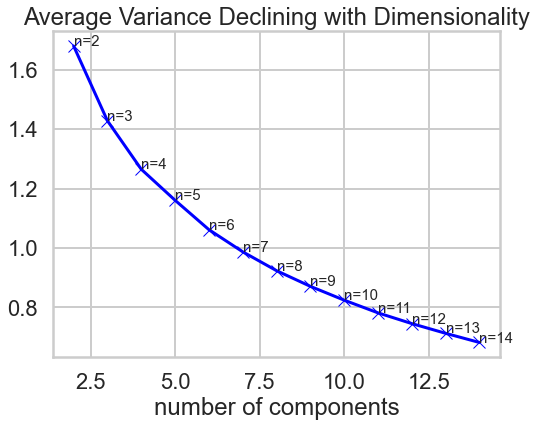

In [421]:
plt.figure(figsize=(8,6))
plt.plot(list(range(2,15)), variances, 'bx-')
for xy in zip(list(range(2,15)), variances):
    plt.annotate('n=%s' % xy[0], xy=xy, textcoords='data', fontsize = 15)
plt.title('Average Variance Declining with Dimensionality')
plt.xlabel('number of components')
plt.show()

There is no clear-cut winner but 6 is satisfactory.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

Conclusion:  PCA used with kmeans techniques can provide meaningful subsets of raw data that can be validated with various scoring techniques.  However, these efforts are still limited by the size and quality of the data set where either is lacking.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [422]:
# Your turn
from sklearn.cluster import AffinityPropagation
random_state = None
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize

<b>Affinity propagation:<b>

Using x_cols for ease of scatter plotting:

In [423]:
afprop = AffinityPropagation(max_iter=250)
afprop.fit(x_cols)

C:\Users\locator\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


AffinityPropagation(max_iter=250)

In [424]:
P = afprop.predict(x_cols)
np.sort(pd.Series(P).unique())

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

Here is a side-by side scatterplot comparison of Affinity Propagation and kmeans clustering:

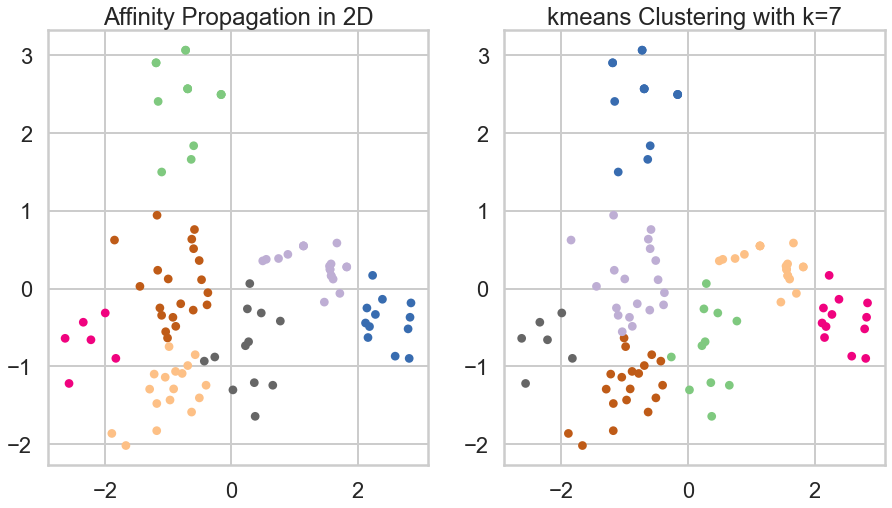

In [425]:
fig = plt.figure(figsize=(20,8))
fig.set_figwidth(15)

plt.subplot(1,2,1)
plt.scatter(x_cols[:,0], x_cols[:,1], c= P, cmap = 'Accent', s=45)
plt.title('Affinity Propagation in 2D')

plt.subplot(1,2,2)
plt.scatter(x_cols[:,0], x_cols[:,1], c= label_sets[7], cmap = 'Accent', s=45)
plt.title('kmeans Clustering with k=7')

plt.show()

Although the two are color-coded differently, the result is absolutely the same.  The key take-away is that Affinity Propagation reinforces the intuition of assigning 7 to k.

<b>Spectral clustering:<b>

As before, let the number of clusters equal 2 because of the extremely small size of the data set.

In [426]:
spectral_model_rbf = SpectralClustering(n_clusters = 2, affinity ='rbf')

In [427]:
labels_rbf = spectral_model_rbf.fit_predict(x_cols)

In [428]:
labels_rbf

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [429]:
pd.DataFrame(labels_rbf).value_counts()

1    86
0    14
dtype: int64

In [430]:
np.sum(labels_rbf)

86

We will compare kmeans to spectral clustering.  Scoring based on either sum of squares distortion or silhouette analysis is of no meaning in the case of spectral clustering because of the very nature of this technique which requires the chaining of points into a single cluster that may actually be very distant from each other but are connected by a pathway going from point to point.  Clearly the 86 to 14 split reflects an approach that yields very different results from the segmentation accomplished above leading to a 64 to 36 split.  The best way to make this comparison is to redo the 6-panel 'Sales Outcome of Two-way Segmetation' that was done in the kmeans case and look for either more or less separation in sales outcomes between groups within the 86 to 14 split vs the split arrived at earlier.  This will require a recalulation of the adjustment off of the ratio of the sizes of the two groups.

In [431]:
adjustment_s = np.sum(labels_rbf)/(100 - np.sum(labels_rbf))
adjustment_s

6.142857142857143

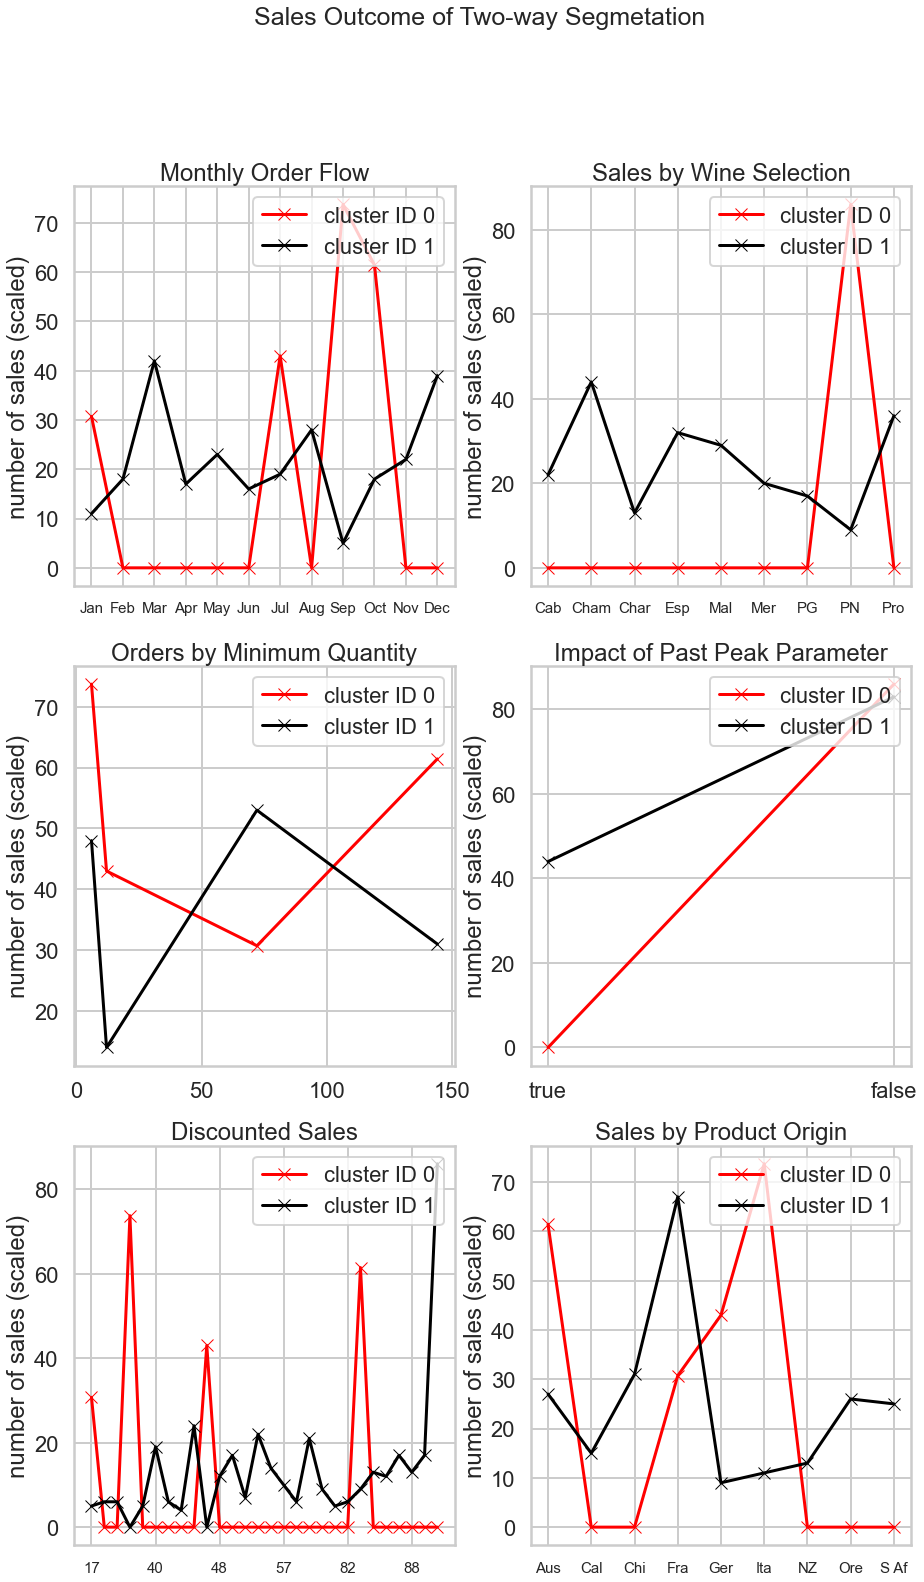

In [432]:
sales_plotter(labels_rbf, adjustment_s)

These yield different results from the 64-36 breakdown but with the smaller of the two groups containing only 14 data points, it can not be said conclusively which is better.

<b>Agglomerative clustering:<b>

In [433]:
from sklearn.cluster import AgglomerativeClustering
agglomerative_model = AgglomerativeClustering(n_clusters=2)
labels_ag = agglomerative_model.fit_predict(x_cols)
labels_ag

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int64)

As with spectral clustering, there are no cluster centers in this approach, thus eliminating the scoring techniques used for kmeans.  We will move directly to the 6-panel plotting of sales outcomes.  First, the adjustment by cluster size ratio:

In [447]:
adjustment_ag = np.sum(labels_ag)/(100 - np.sum(labels_ag))
adjustment_ag

0.4492753623188406

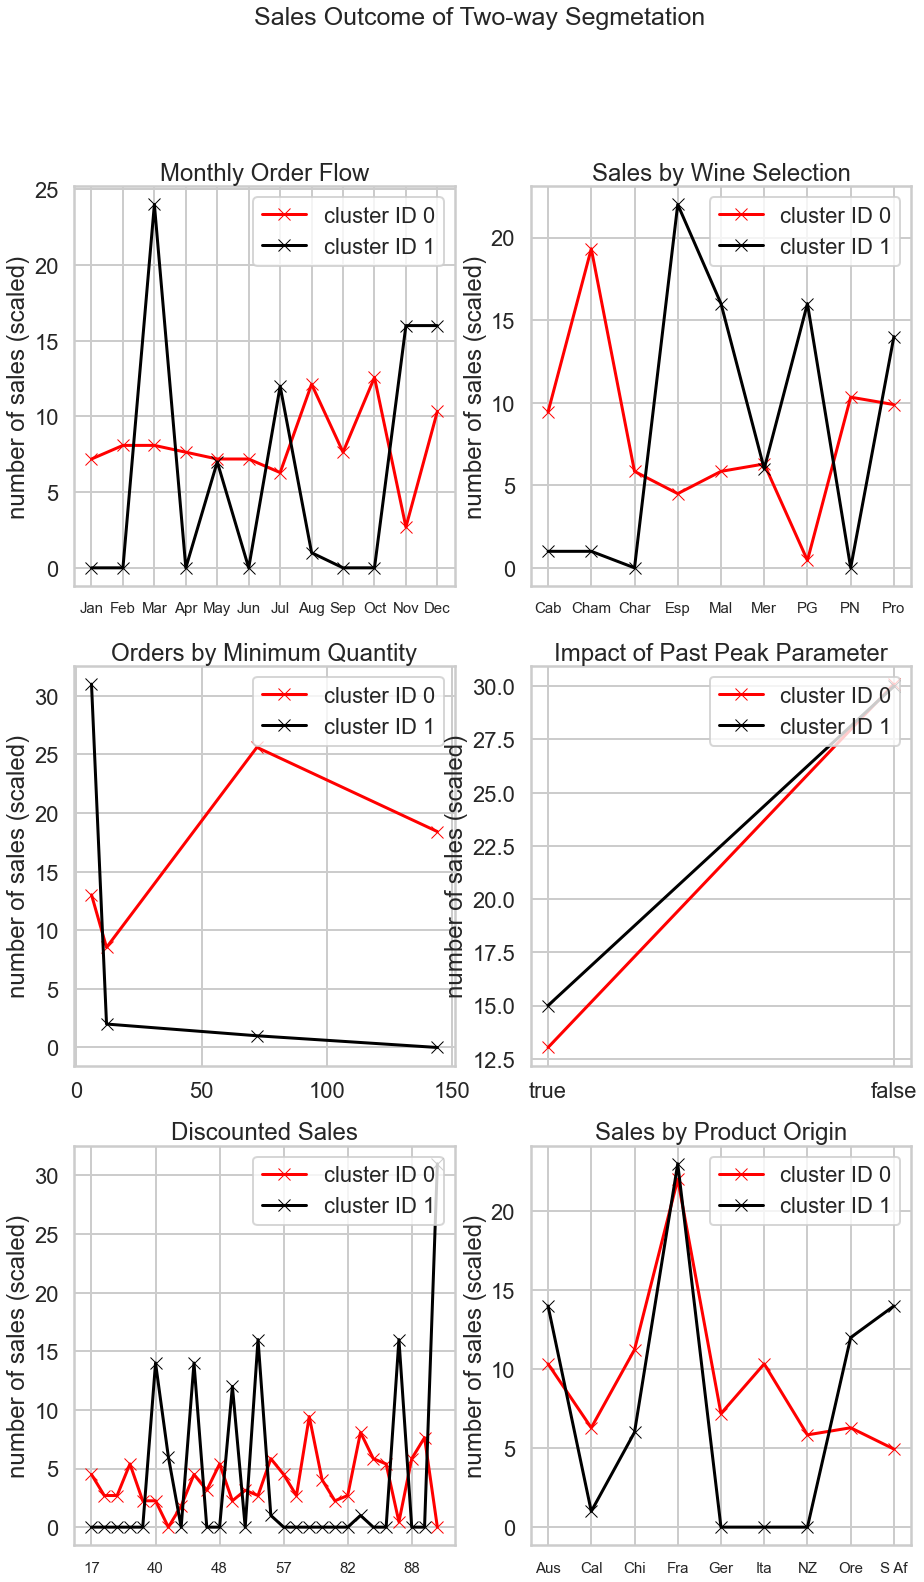

In [448]:
sales_plotter(labels_ag, adjustment_ag)

The most interesting part of this rendering is that it confirms the assertion from the kmeans plots that there is a population of wine customers who are very much in the habit of ordering in March.

<b>DBSCAN:<b>

Using this method for a sample size of only 100, will require of us that we adust the two parameters of the model definition to allow only two clusters.  This is another type of model that does not take distances from cluster centers.

In [436]:
from sklearn.cluster import DBSCAN
dbscan_model = DBSCAN(eps=0.30, min_samples=9)
labels_db = dbscan_model.fit_predict(x_cols)
labels_db

array([-1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1],
      dtype=int64)

In [437]:
labels_db = labels_db*-1
labels_db

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [438]:
pd.DataFrame(labels_db).value_counts()

1    89
0    11
dtype: int64

In [439]:
adjustment_db = np.sum(labels_db)/(100 - np.sum(labels_db))
adjustment_db

8.090909090909092

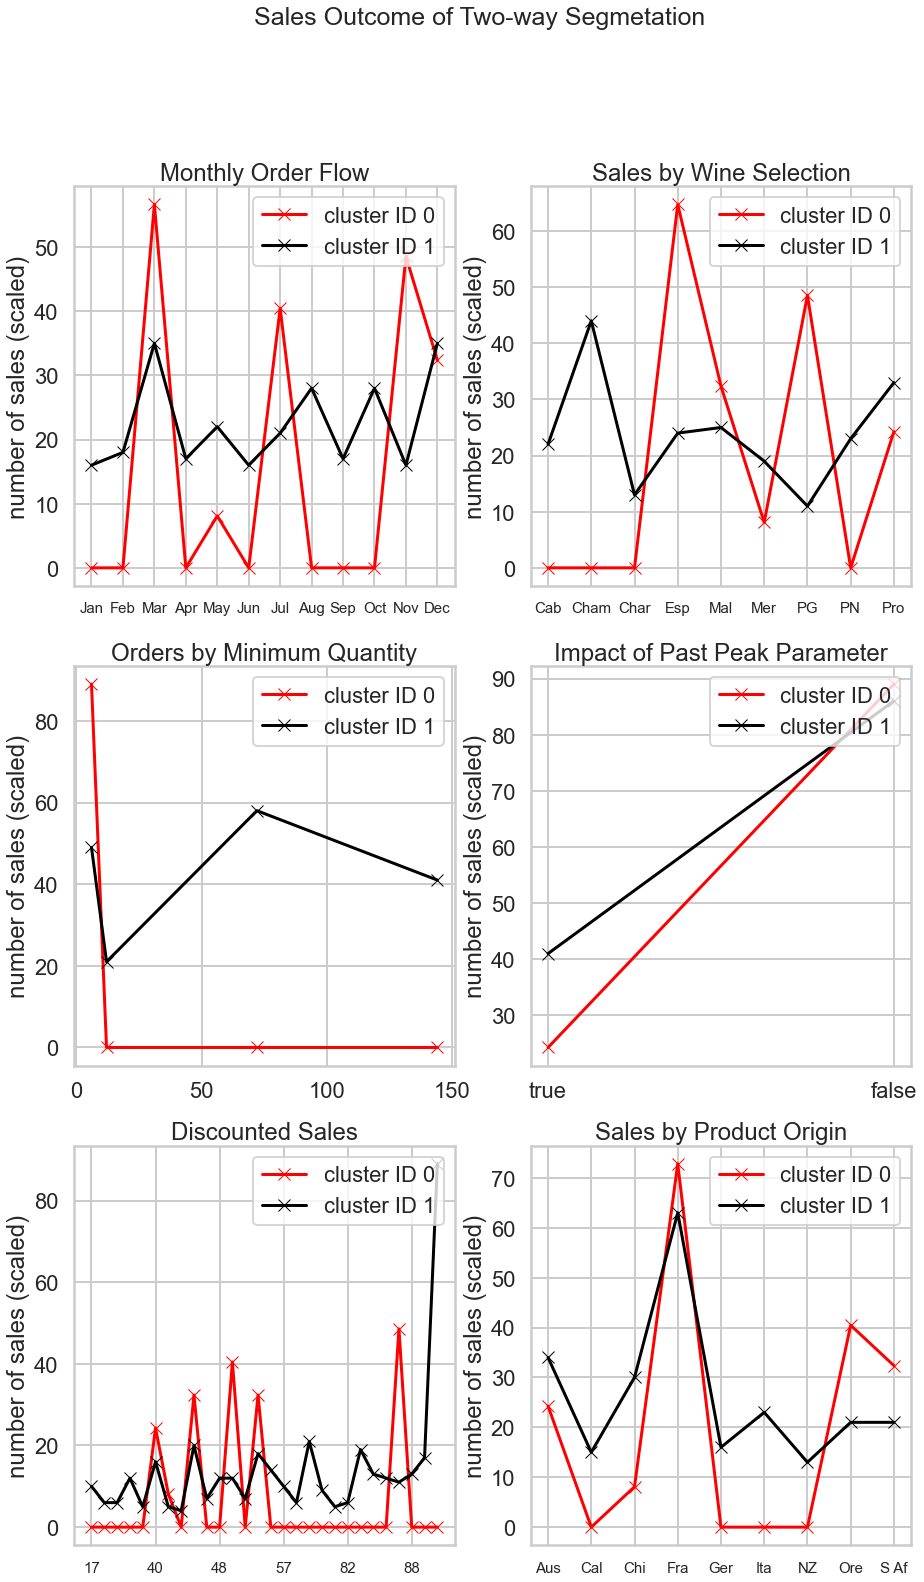

In [440]:
sales_plotter(labels_db, adjustment_db)

This approach has not provided any new information.  A determination of which approach performs the best will really have to await more data.  But for now the most useful approach is Affinity Propagation because it provides an excellent complement to kmeans by strongly suggesting how many clusters to create.